In [50]:
import croissant as cro
import croissant.jax as crojax
from functools import partial
from healpy import projview
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel16 as GSM16
import s2fft

import tools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
sim = tools.Simulator(fname="sim_params.yaml")

#### Beam

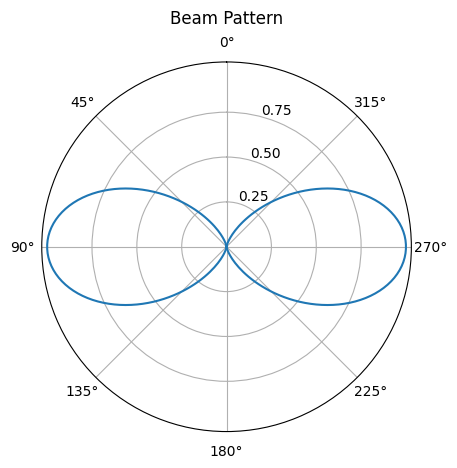

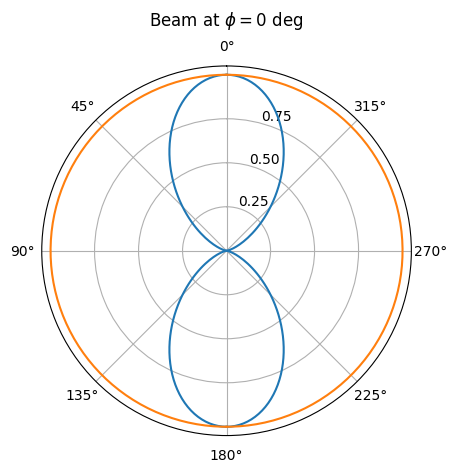

In [75]:
def plot_polar(beam, title="Beam Pattern"):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(theta, beam, c="C0")
    ax.plot(-theta, beam, c="C0")
    ax.set_rmax(1.03)
    ax.set_rticks([0.25, 0.5, 0.75])
    ax.set_rlabel_position(-15)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.set_theta_zero_location("N")
    ax.set_title(title, va="bottom")
    return ax

# we use a coiled dipole that acts as a half-wavelength dipole at each frequency
# radiation pattern is given in Balanis, page 182 (section 4.6)
beamZ = jnp.sin(sim.theta)**3
_ = plot_polar(beamZ)

beamX, beamY = sim.beam(return_xy=True)

phi_plot = 0
ax = plot_polar(beamX[:, phi_plot], title=f"Beam at $\\phi={phi_plot}$ deg")
ax.plot(theta, beamY[:, phi_plot], c="C1")
ax.plot(-theta, beamY[:, phi_plot], c="C1")
plt.show()

In [76]:
# dt = cro.constants.sidereal_day[world] / ntimes
# phases = crojax.simulator.rot_alm_z(LMAX, ntimes, dt, world=world)

# # get the euler angles and wigner d functions for the coordinate transforms
# eul_topo, dl_topo = crojax.rotations.generate_euler_dl(LMAX, topo, "fk5")  # beam transform, from topocentric to mcmf
# eul_gal, dl_gal = crojax.rotations.generate_euler_dl(LMAX, "galactic", "fk5")  # sky transform, from galactic to mcmf

# topo2eq = partial(s2fft.utils.rotation.rotate_flms, L=LMAX+1, rotation=eul_topo, dl_array=dl_topo)
# gal2eq = partial(s2fft.utils.rotation.rotate_flms, L=LMAX+1, rotation=eul_gal, dl_array=dl_gal)

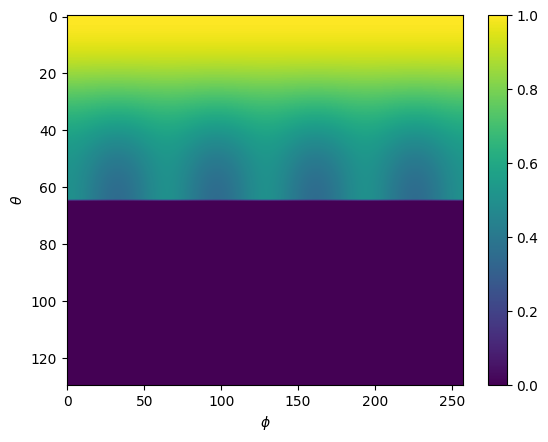

In [78]:
beam = sim.beam()
plt.figure()
plt.imshow(beam*sim.horizon[0], aspect="auto")
plt.colorbar()
plt.ylabel("$\\theta$")
plt.xlabel("$\\phi$")
plt.show()

beam = jnp.repeat(beam[None], freq.size, axis=0)  # achromatic beam for now

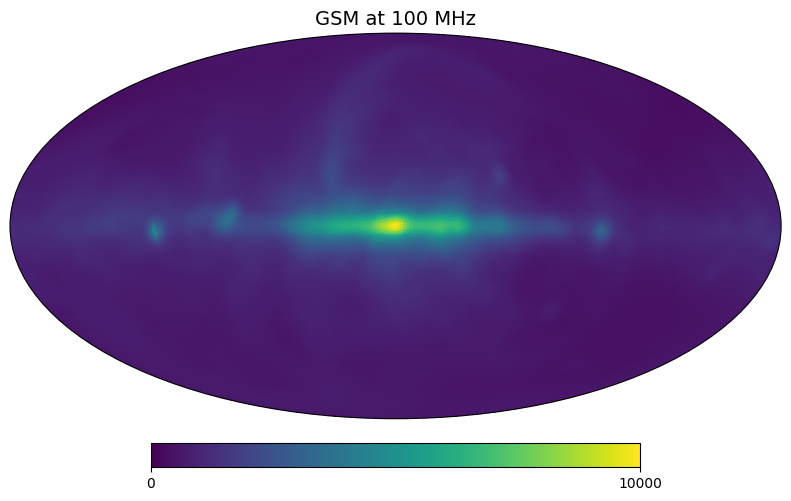

In [79]:
gsm = GSM16(freq_unit="MHz", data_unit="TRJ", resolution="lo")
sky_map = gsm.generate(sim.freq)
ix = 49
projview(m=sky_map[ix], title=f"GSM at {freq[ix]:.0f} MHz", min=0, max=1e4)
plt.show()

In [80]:
# # define the map2alm transform for signals sampled with mwss (like beam and horizon)
# mwss2alm = partial(s2fft.forward_jax, L=LMAX+1, spin=0, nside=None, sampling="mwss", reality=True)
# # define the map2alm transform for signals sampled with healpix
# nside = get_nside(sky_map[0])
# hp2alm = partial(s2fft.forward_jax, L=LMAX+1, spin=0, nside=nside, sampling="healpix", reality=True)

# # alm decompositions (see table 1 in the paper)
# alm = jax.vmap(mwss2alm)(beam*horizon_mask)
# blm = jax.vmap(mwss2alm)(beam*(1-horizon_mask))
# clm = jax.vmap(hp2alm)(sky_map)
# dlm = jax.vmap(mwss2alm)(horizon_mask)
# # flm = jax.vmap(hp2alm)(tx_map)

# # total power = 2 * sqrt(pi) * a00
# alm_power = crojax.alm.total_power(alm, LMAX)
# blm_power = crojax.alm.total_power(blm, LMAX)
# norm = alm_power + blm_power

# # modify dlm like in paper
# eps = 1e-3  # coupling coefficient for scattering
# dlm *= eps * blm_power[:, None, None]

# # coordinate transforms
# alm = jax.vmap(topo2eq)(alm)
# blm = jax.vmap(topo2eq)(blm)
# clm = jax.vmap(gal2eq)(clm)
# dlm = jax.vmap(topo2eq)(dlm)
# #flm = jax.vmap(topo2eq)(flm)

In [83]:
alm, blm = sim.compute_alms(beam, sky_map)

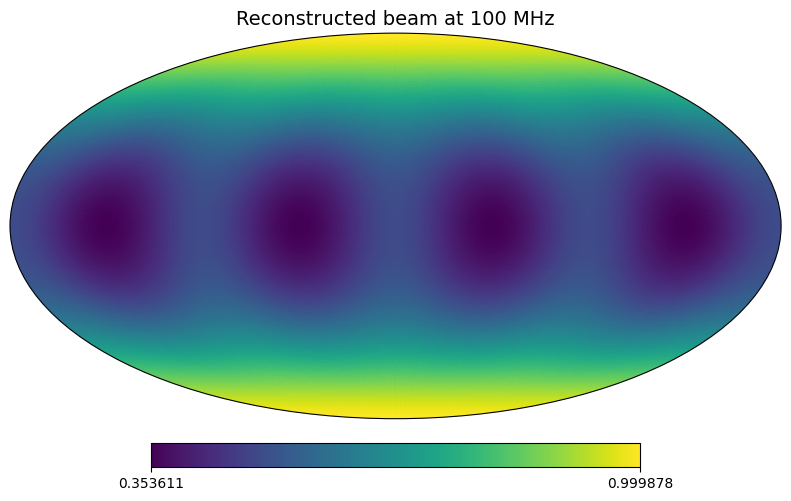

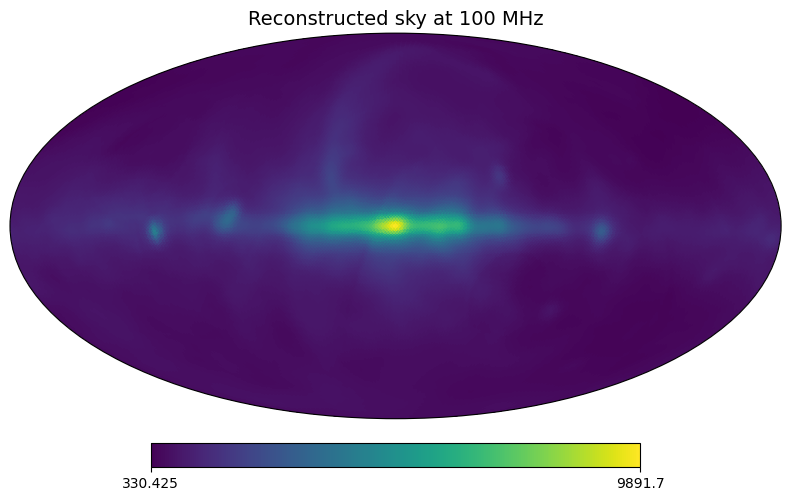

In [84]:
# beam and sky as seen by simulator after transformed back to healpix
beam_reconstructed = s2fft.inverse_jax(alm[ix], L=sim.lmax+1, spin=0, nside=sim.nside, sampling="healpix", reality=True).real
sky_reconstructed = s2fft.inverse_jax(blm[ix], L=sim.lmax+1, spin=0, nside=sim.nside, sampling="healpix", reality=True).real

projview(m=beam_reconstructed, title=f"Reconstructed beam at {sim.freq[ix]:.0f} MHz")
projview(m=sky_reconstructed, title=f"Reconstructed sky at {sim.freq[ix]:.0f} MHz")
plt.show()

In [9]:
T_bb = 300  # ground blackbody contribution

# Equations 15 and 16 from the paper for computing T_ant
h = 100  # eigsep height is 100m
c = 2992792458  # m/s
tau = 2*h/c
dly_phase = 2*jnp.pi*(freq[:, None, None]*1e6)*tau  # multiply by 1e6 to get freq in Hz
T_ant = crojax.simulator.convolve(alm + dlm * jnp.exp(-1j*dly_phase), clm, phases).real
#T_ant += crojax.simulator.convolve(blm, flm, jnp.ones_like(phases)).real  # tx contribution
T_ant += blm_power * T_bb
T_ant /= norm

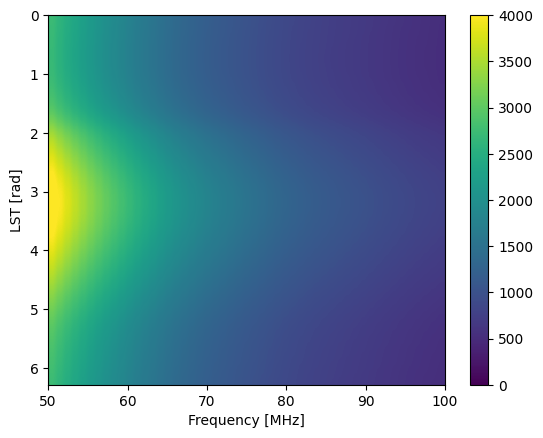

In [10]:
cmin = 0
cmax = 4000
plt.figure()
im = plt.imshow(T_ant, aspect="auto", extent=[freq.min(), freq.max(), 2*jnp.pi, 0])
im.set_clim(cmin, cmax)
plt.colorbar()
plt.ylabel("LST [rad]")
plt.xlabel("Frequency [MHz]")
plt.show()

In [ ]:
def loss(beam_model, sky_model):
    t_hat = forward_sim(beam_model, sky_model)
    diff = T_ant - t_hat
    return jnp.sum(diff**2)

def forward_sim(beam_model, sky_model)